# Use ONNX model converted from TensorFlow to recognize hand-written digits with `ibm-watsonx-ai`

This notebook facilitates `ONNX`, `Tensorflow (and TF.Keras)`, and `watsonx.ai Runtime` service. It contains steps and code to work with [ibm-watsonx-ai](https://pypi.python.org/pypi/ibm-watsonx-ai) library available in PyPI repository in order to convert the TensorFlow model to ONNX format. It also introduces commands for getting model and training data, persisting model, deploying model and scoring it.

Some familiarity with Python is helpful. This notebook uses Python 3.11.

## Learning goals

The learning goals of this notebook are:

-  Download an externally trained TensorFlow model with dataset.
-  Convert TensorFlow model to ONNX format 
-  Persist converted model in watsonx.ai Runtime repository.
-  Deploy model for online scoring using client library.
-  Score sample records using client library.


## Contents

This notebook contains the following parts:

1.	[Setting up the environment](#setup)
2.	[Downloading externally created TensorFlow model and data](#download)
3.	[Converting TensorFlow model to ONNX format](#convert)
4.	[Persisting converted ONNX model](#upload)
5.	[Deploying and scoring ONNX model](#deploy)
6.  [Cleaning up](#cleanup)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setting up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [watsonx.ai Runtime](https://cloud.ibm.com/catalog/services/watsonxai-runtime) instance (information on service plans and further reading can be found [here](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp)).

### 1.1. Installing and importing the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install matplotlib | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install tensorflow==2.14 | tail -n 1
!pip install tf2onnx==1.16 | tail -n 1
!pip install onnxruntime==1.16.3 | tail -n 1

In [35]:
import getpass
import json
import logging
import tf2onnx
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import wget
from ibm_watsonx_ai import Credentials, APIClient
from keras.models import load_model

### 1.2. Connecting to watsonx.ai Runtime

Authenticate to the watsonx.ai Runtime service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your watsonx.ai Runtime instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the watsonx.ai Runtime docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cells.

In [3]:
api_key = getpass.getpass("Please enter your api key (hit enter): ")

Please enter your api key (hit enter):  ········


In [4]:
location = 'ENTER YOUR LOCATION HERE'

If you are running this notebook on Cloud, you can access the `location` via:

```
location = os.environ.get("RUNTIME_ENV_REGION")
```

In [5]:
credentials = Credentials(
    api_key=api_key,
    url=f'https://{location}.ml.cloud.ibm.com'
)

In [6]:
client = APIClient(credentials=credentials)

### 1.3. Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select watsonx.ai Runtime instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use the `ibm_watsonx_ai` SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [7]:
space_id = 'ENTER YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in watsonx.ai Runtime, you need to set **space** which you will be using.

In [9]:
client.set.default_space(space_id)

'SUCCESS'

<a id="download"></a>
## 2. Downloading externally created TensorFlow model and data
In this section, you will download externally created TensorFlow models and data used for training it. You can choose to download either a **TensorFlow** or a **Keras** model.

### 2.1. Downloading dataset

In [10]:
data_dir = Path('MNIST_DATA')
if not data_dir.is_dir():
    data_dir.mkdir()

In [11]:
data_path = data_dir / 'mnist.npz'
if not data_path.is_file():
    wget.download('https://s3.amazonaws.com/img-datasets/mnist.npz', out=str(data_dir))

In [12]:
dataset = np.load(data_path)
x_test = dataset['x_test']

### 2.2. Downloading TensorFlow model

In [13]:
tf_model_name = 'mnist-tf-hpo-saved-model'
model_tar_name = f'{tf_model_name}.tar.gz'
model_path = data_dir / model_tar_name

if not model_path.is_file():
   wget.download(f"https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/models/tensorflow/mnist/{model_tar_name}", out=str(data_dir))  

### 2.3. (OPTIONAL) Downloading TensorFLow Keras model

To download the TensorFLow Keras model, change the `Markdown` cell below to a `Code` cell and remove the triple backticks (` ``` `).

```
tf_model_name = 'mnist_cnn.h5'
model_tar_name = f'mnist_keras.h5.tgz'
model_path = data_dir / model_tar_name

if not model_path.is_file():
   wget.download(f"https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/models/keras/{model_tar_name}", out=str(data_dir))
```

<a id="convert"></a>
## 3. Converting TensorFlow model to ONNX format
In this section, you will unpack externally created TensorFlow models, provided in either SavedModel or Keras format (depending on your earlier selection), from the tar archive and convert them to the ONNX format. More information can be found [here](https://onnxruntime.ai/docs/tutorials/tf-get-started.html).

In [14]:
onnx_model_name = "tf_model.onnx"

### 3.1. Converting TensorFlow SavedModel

In [15]:
!mkdir -p {tf_model_name}
!tar xzf MNIST_DATA/{model_tar_name} -C {tf_model_name}

**Note:** If you are working with TensorFlow Lite models, make sure to use the `--tflite` flag instead of `--saved-model`.

In [ ]:
!python -m tf2onnx.convert --saved-model {tf_model_name} --output {onnx_model_name}

In [18]:
onnx_model = onnx.load(onnx_model_name)

### 3.2. (OPTIONAL) Converting TensorFLow Keras model

To convert the TensorFLow Keras model to ONNX format, change the `Markdown` cells below to a `Code` cells and remove the triple backticks (` ``` `).

```
!tar xzf MNIST_DATA/{model_tar_name}
```

```
logging.getLogger().setLevel(logging.ERROR)

model = load_model(tf_model_name)
onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx.save(onnx_model, onnx_model_name)
```

<a id="evaluation-onnx"></a>
### 3.3. Evaluating the ONNX Model

After exporting the model, you should verify its integrity and ensure that it functions as expected. We will use `onnxruntime` to load the model and perform inference on the test data. Additionally, we’ll use `onnx`'s `checker` module to validate the exported ONNX model.


In [19]:
onnx.checker.check_model(onnx_model)

In [21]:
session = ort.InferenceSession(onnx_model_name)
x_test = np.array(x_test, dtype=np.float32).reshape(-1, 784) # flattened image 28*28=784
input_data = {session.get_inputs()[0].name: x_test[:2]}
session.run([], input_data)

[array([7, 2], dtype=int64)]

<a id="upload"></a>
## 4. Persisting converted ONNX model

In this section, you will learn how to store your converted ONNX model in watsonx.ai Runtime repository using the IBM watsonx.ai SDK.

### 4.1. Publishing model in watsonx.ai Runtime repository

Define model name, type and software spec.

In [22]:
sofware_spec_id = client.software_specifications.get_id_by_name("onnxruntime_opset_19")
onnx_model_zip = "tf_onnx.zip"

In [23]:
!zip {onnx_model_zip} {onnx_model_name}

  adding: tf_model.onnx (deflated 7%)


In [24]:
metadata = {
    client.repository.ModelMetaNames.NAME: 'TensorFLow to ONNX converted model',
    client.repository.ModelMetaNames.TYPE: 'onnxruntime_1.16',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: sofware_spec_id
}

published_model = client.repository.store_model(
    model=onnx_model_zip,
    meta_props=metadata
)

### 4.2. Getting model details

In [ ]:
published_model_id = client.repository.get_model_id(published_model)
model_details = client.repository.get_details(published_model_id)
print(json.dumps(model_details, indent=2))

<a id="deploy"></a>
## 5. Deploying and scoring ONNX model

In this section you'll learn how to create an online scoring service and predict on unseen data.

### 5.1. Creating online deployment for published model

In [26]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of TensorFLow to ONNX converted model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_id, meta_props=metadata)



######################################################################################

Synchronous deployment creation for id: '625fd702-1fcb-4487-9379-a8f6b41f5726' started

######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
..
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='141a566d-768c-4ed7-b922-bc40245952d9'
-----------------------------------------------------------------------------------------------




In [27]:
deployment_id = client.deployments.get_id(created_deployment)

Now you can print an online scoring endpoint. 

In [ ]:
client.deployments.get_scoring_href(created_deployment)

### 5.2. Getting deployment details

In [ ]:
client.deployments.get_details(deployment_id)

<a id="score"></a>
### 5.3. Scoring

You can use below method to do test scoring request against deployed model.

Let's first visualize two samples from dataset, we'll use for scoring.

In [30]:
%matplotlib inline

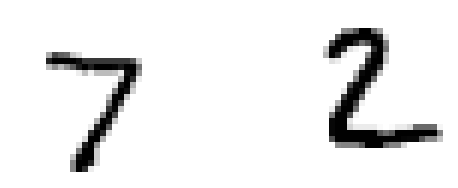

In [31]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')

Prepare scoring payload with records to score.

In [32]:
scoring_payload = {"input_data": [{"values": x_test[:2].tolist()}]}

Use ``client.deployments.score()`` method to run scoring.

In [33]:
predictions = client.deployments.score(deployment_id, scoring_payload)

Let's print the result of predictions.

In [34]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "id": "classes",
      "values": [
        7,
        2
      ]
    }
  ]
}


As you can see, the predicted values are consistent with those calculated in the [evaluation](#evaluation-onnx) section.

<a id="cleanup"></a>
## 6. Cleaning up

If you want to clean up after the notebook execution, i.e. remove any created assets like:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 7. Summary and next steps

 You successfully completed this notebook! You learned how to use ONNX, TensorFlow machine learning library as well as watsonx.ai for model creation and deployment. Check out our _[Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=wx)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Michał Koruszowic**, Software Engineer

Copyright © 2024-2025 IBM. This notebook and its source code are released under the terms of the MIT License.